# Testing Mitiq ZNE in OpenQAOA

## 1. Creation of the graph + QUBO model

In [1]:
from tqdm import tqdm
from openqaoa.problems.maximumcut import MaximumCut
from openqaoa.backends import create_device

import networkx as nx
from openqaoa import QAOA  
from openqaoa.problems import MaximumCut
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
from openqaoa.utilities import plot_graph
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']


In [2]:
def add_depolarizing_error(noise_model,prob1, prob2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob2)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.01, 0.01) #ibm_quebec, 19/01/2024

In [3]:
def create_graph(nodes,edges):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
    return graph

In [4]:
from openqaoa import QAOA
import networkx as nx
from openqaoa.problems import Knapsack
from openqaoa.utilities import plot_graph

In [5]:
knapsack_prob = Knapsack.random_instance(n_items = 5)
knapsack_prob.values, knapsack_prob.weights, knapsack_prob.weight_capacity, knapsack_prob.penalty

([1, 2, 1, 3, 3], [4, 3, 1, 3, 3], 5, 6)

In [6]:
kp1 = Knapsack([2, 4, 4, 4, 3], [2, 2, 2, 3, 4], 14, 8 )
kp1.values, kp1.weights, kp1.weight_capacity, kp1.penalty

([2, 4, 4, 4, 3], [2, 2, 2, 3, 4], 14, 8)

In [7]:
q1 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q1.set_device(qiskit_device)
q1.set_circuit_properties(p=1, param_type="standard", init_type="rand", mixer_hamiltonian="x", seed = 1)
q1.set_backend_properties(n_shots=5000, seed_simulator=1)
q1.set_classical_optimizer(method="Nelder-Mead", maxiter=200, tol=0.001,
optimization_progress=True, cost_progress=True, parameter_log=True)
q1.compile(kp1.qubo)
q1.optimize()
correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
print(correct_solution1)
opt_results1 = q1.result



KeyboardInterrupt



In [24]:
q1 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q1.set_device(qiskit_device)
q1.set_circuit_properties(p=1, param_type="standard", init_type="rand", mixer_hamiltonian="x", seed = 1)
q1.set_backend_properties(n_shots=5000, seed_simulator=1)
q1.set_classical_optimizer(method="COBYLA", maxiter=200, tol=0.001,
optimization_progress=True, cost_progress=True, parameter_log=True)
q1.compile(kp1.qubo)
q1.optimize()
correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
print(correct_solution1)
opt_results1 = q1.result

(-17.0, ['100011111'])


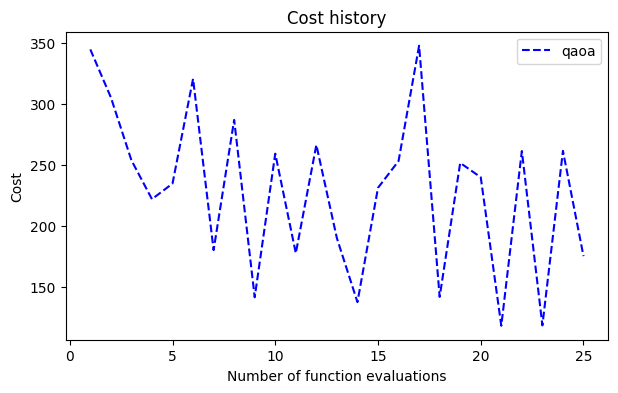

In [26]:

fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa',ax=ax)
#opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax)
plt.savefig("kp1-powell.png")

In [7]:
noise_model = add_depolarizing_error(NoiseModel(),0.01, 0.01)

In [30]:
q2 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q2.set_device(qiskit_device)
q2.set_circuit_properties(p=1, param_type="standard", init_type="rand", mixer_hamiltonian="x", seed = 1)
q2.set_backend_properties(n_shots=5000, seed_simulator=1,
                        noise_model=noise_model)
q2.set_classical_optimizer(method="Nelder-Mead", maxiter=200, tol=0.001,
optimization_progress=True, cost_progress=True, parameter_log=True)
q2.compile(kp1.qubo)
q2.optimize()
opt_results2 = q2.result

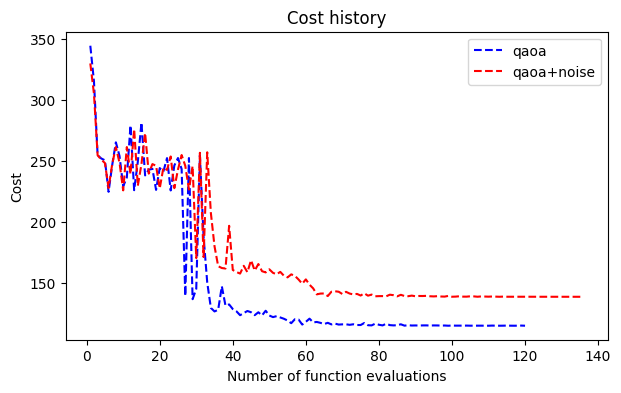

In [31]:
fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax)
plt.savefig("kp1-nelder-mead-noise.png")

In [26]:
scale_factors=[1,2.2]
assert isinstance(scale_factors, list) and \
       all(isinstance(x, int) and x >= 1 for x in scale_factors), \
       "Scale factors must be a list of ints >= 1"

AssertionError: Scale factors must be a list of ints >= 1

In [28]:
q3 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q3.set_device(qiskit_device)
q3.set_circuit_properties(p=1, param_type="standard", init_type="rand", mixer_hamiltonian="x", seed = 1)
q3.set_backend_properties(n_shots=5000, seed_simulator=1,
                        noise_model=noise_model)
q3.set_classical_optimizer(method="Cobyla", maxiter=200, tol=0.001,
optimization_progress=True, cost_progress=True, parameter_log=True)
#q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',factory='Poly',scaling = 'fold_gates_from_right',scale_factors=[1,2,4],order=2)
#q3.set_error_mitigation_properties(error_mitigation_technique='spam_twirling',calibration_data_location='./caldata.json')
display(q3.error_mitigation_properties.asdict())
q3.compile(kp1.qubo)
q3.optimize()
opt_results3 = q3.result

{'error_mitigation_technique': 'spam_twirling',
 'n_batches': 10,
 'calibration_data_location': './caldata.json'}

KeyError: 0

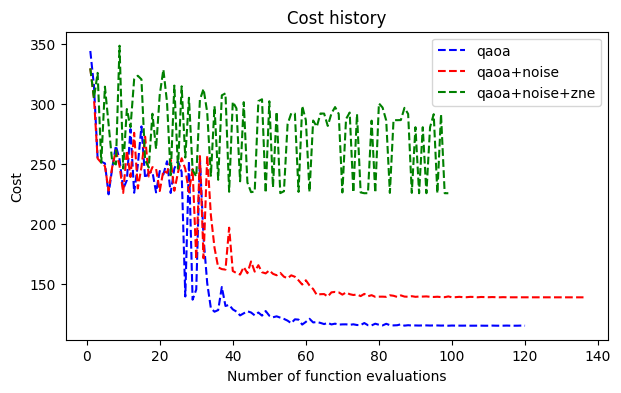

In [40]:
fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa', ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise', ax=ax)
opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne', ax=ax)
plt.savefig("test-nelder-mead-adaexp.png")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(0, 4), (0, 9), (1, 2), (1, 3), (1, 6), (2, 5), (2, 7), (2, 8), (2, 9), (3, 5), (3, 6), (3, 8), (4, 5), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7), (6, 9), (7, 8), (8, 9)]


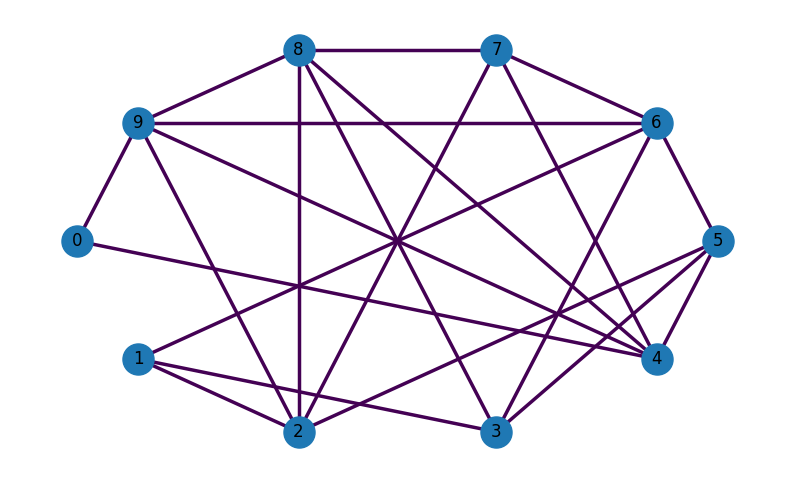

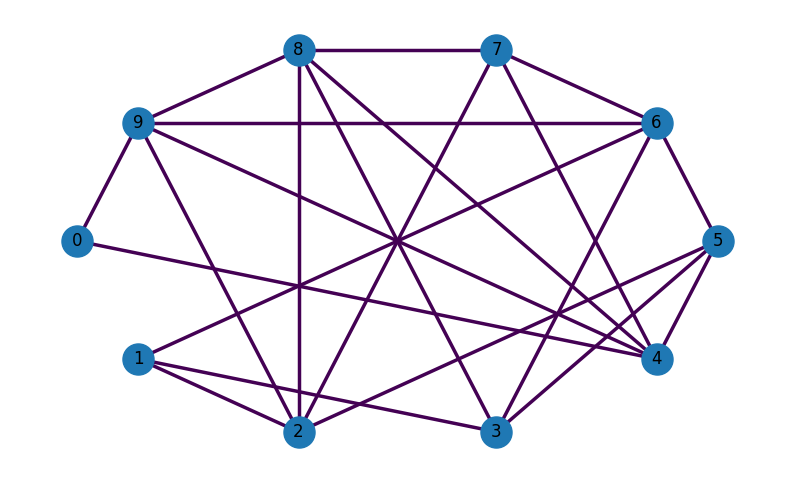

In [1]:
import networkx as nx
from openqaoa.problems import MaximumCut
from openqaoa.utilities import plot_graph
""" G = create_graph(
[0, 1, 2, 3, 4, ],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
) """

#Inner OpenQAOA function for ploting graphs
#plot_graph(graph)

# Create a MaximumCut instance from the graph and get its QUBO and hamiltonian
#maxcut_prob = MaximumCut(G)
maxcut_prob = MaximumCut.random_instance(n_nodes = 10, edge_probability = 0.5)
plot_graph(maxcut_prob.G)
maxcut_qubo = maxcut_prob.qubo
maxcut_hamiltonian = maxcut_qubo.hamiltonian
nodes = maxcut_prob.G.nodes
edges = maxcut_prob.G.edges
print(nodes)
print(edges)
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
plot_graph(graph)

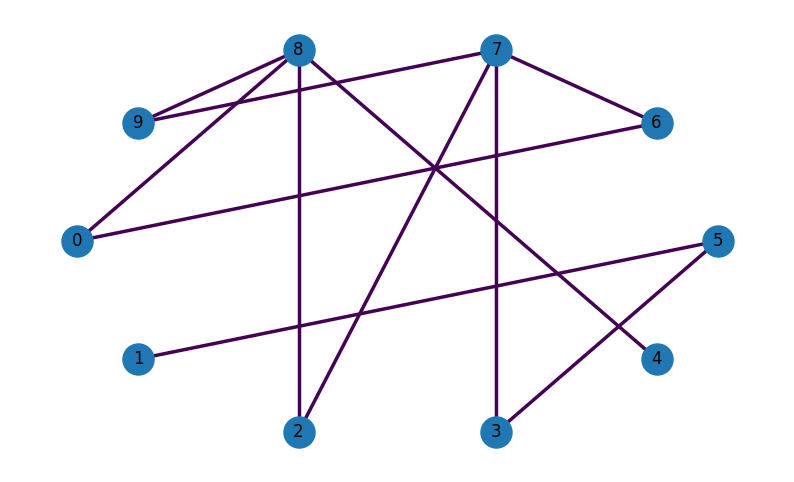

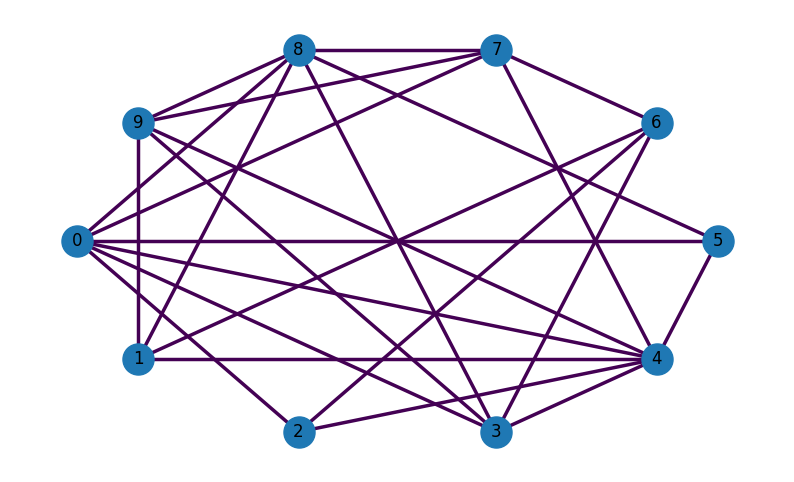

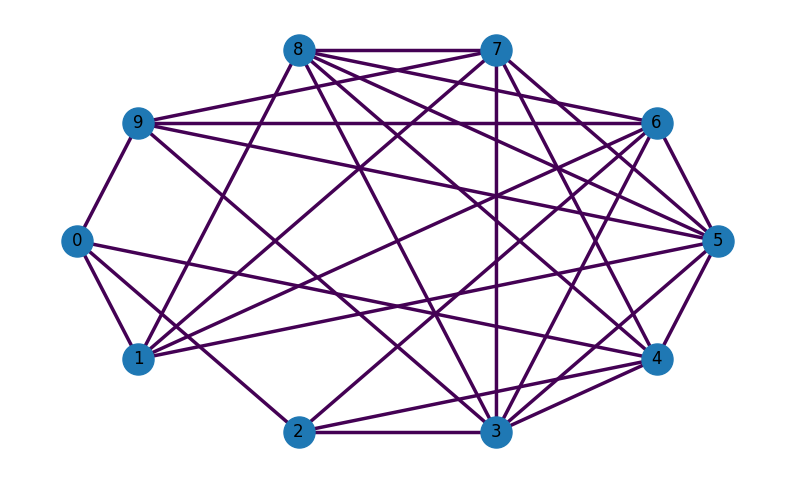

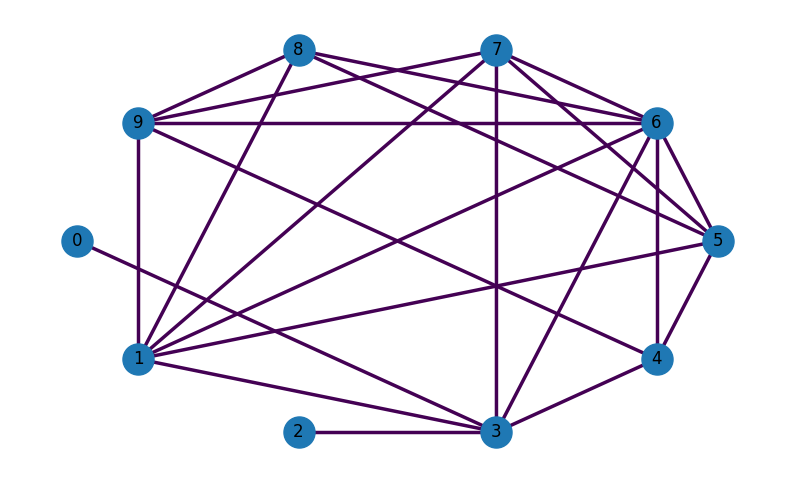

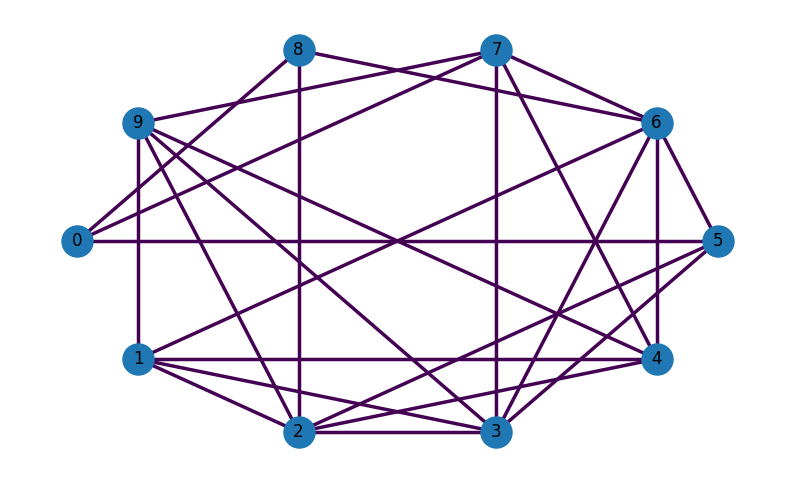

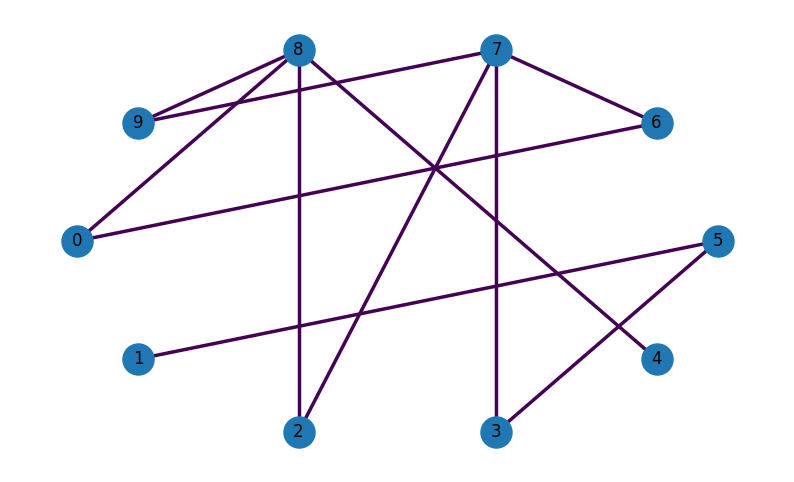

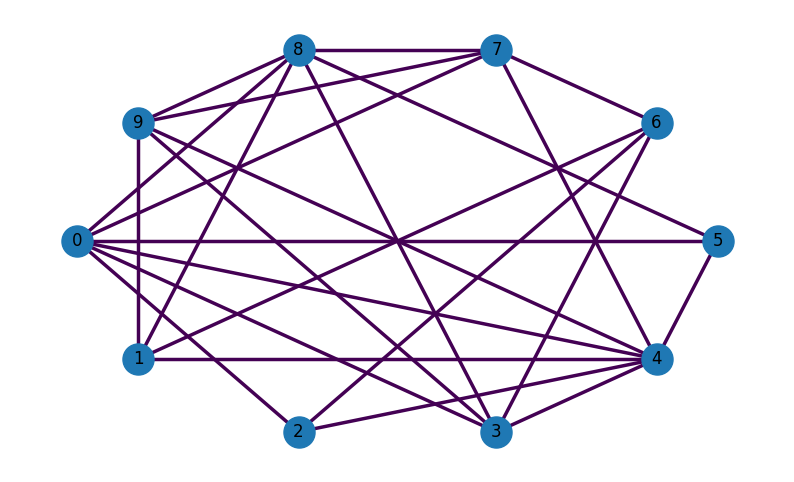

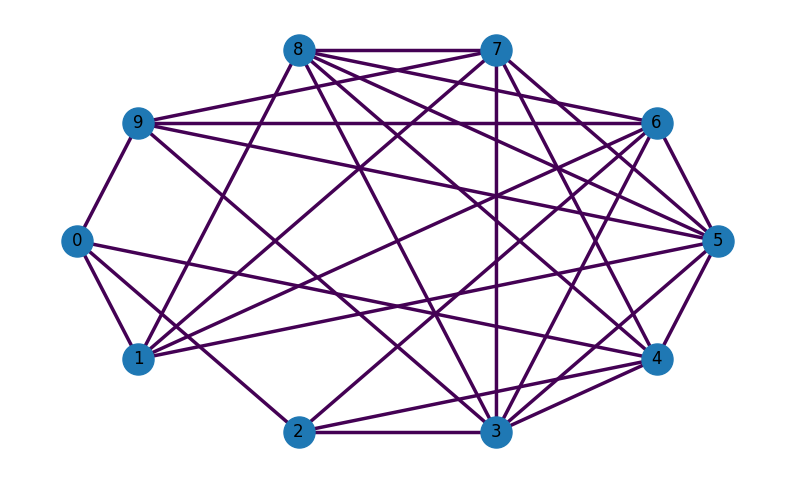

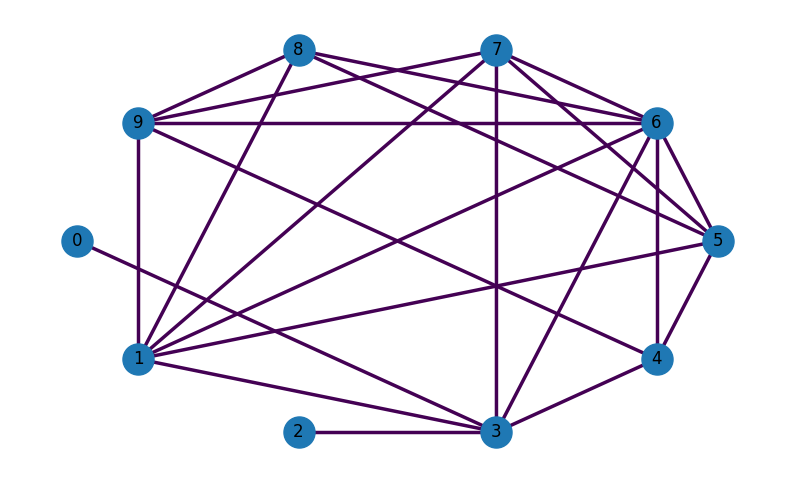

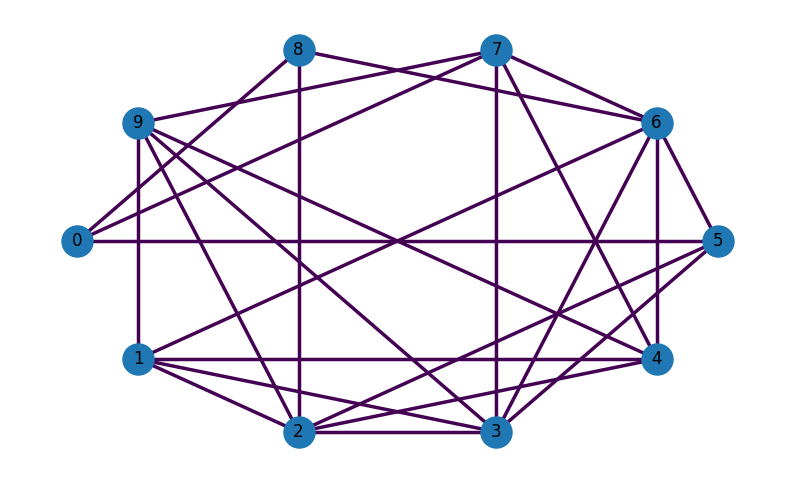

In [2]:
graph1 = nx.Graph()
graph1.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph1.add_edges_from([(0, 6), (0, 8), (1, 5), (2, 7), (2, 8), (3, 5), (3, 7), (4, 8), (6, 7), (7, 9), (8, 9)])

graph2 = nx.Graph()
graph2.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph2.add_edges_from([(0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 4), (1, 6), (1, 8), (1, 9), (2, 4), (2, 6), (3, 4), (3, 6), (3, 8), (3, 9), (4, 5), (4, 7), (4, 9), (5, 8), (6, 7), (7, 8), (7, 9), (8, 9)])

graph3 = nx.Graph()
graph3.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph3.add_edges_from([(0, 1), (0, 2), (0, 4), (0, 9), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9)])

graph4 = nx.Graph()
graph4.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph4.add_edges_from([(0, 3), (1, 3), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (3, 4), (3, 6), (3, 7), (4, 5), (4, 6), (4, 9), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9)])

graph5 = nx.Graph()
graph5.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph5.add_edges_from([(0, 5), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 6), (1, 9), (2, 3), (2, 4), (2, 5), (2, 8), (2, 9), (3, 5), (3, 6), (3, 7), (3, 9), (4, 6), (4, 7), (4, 9), (5, 6), (6, 7), (6, 8), (7, 9)])

mc1 = MaximumCut(graph1)
mc2 = MaximumCut(graph2)
mc3 = MaximumCut(graph3)
mc4 = MaximumCut(graph4)
mc5 = MaximumCut(graph5)

plot_graph(mc1.G)
plot_graph(mc2.G)
plot_graph(mc3.G)
plot_graph(mc4.G)
plot_graph(mc5.G)

plot_graph(mc1.G)
plot_graph(mc2.G)
plot_graph(mc3.G)
plot_graph(mc4.G)
plot_graph(mc5.G)


## 2.  OpenQAOA  

### 2.1. Configuration, compilation and optimization

In [3]:
from tqdm import tqdm
from openqaoa.problems.maximumcut import MaximumCut
from openqaoa.backends import create_device

import networkx as nx
from openqaoa import QAOA  
from openqaoa.problems import MaximumCut
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
from openqaoa.utilities import plot_graph
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']


In [4]:
def add_depolarizing_error(noise_model,prob1, prob2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob2)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.01, 0.01) #ibm_quebec, 19/01/2024

In [7]:
q1 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q1.set_device(qiskit_device)
q1.set_circuit_properties(p=1, param_type="extended", init_type="rand", mixer_hamiltonian="x", seed = 1)
q1.set_backend_properties(n_shots=5000, seed_simulator=1)
q1.set_classical_optimizer(method="Powell", maxiter=200, tol=0.001,
optimization_progress=True, cost_progress=True, parameter_log=True)
q1.compile(mc3.qubo)
q1.optimize()
correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
print(correct_solution1)
opt_results1 = q1.result


(-12.0, ['1001011100', '0110100011'])


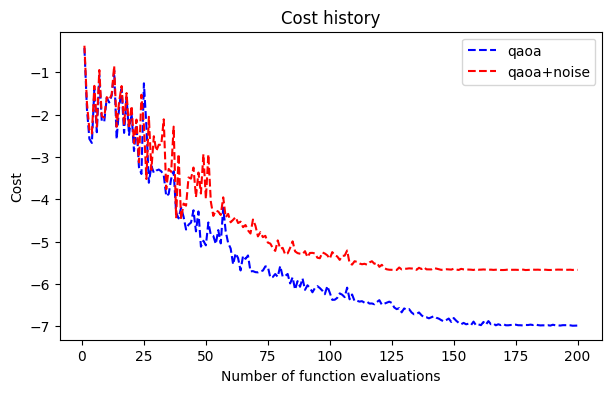

In [8]:
fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax)
plt.savefig("test-cob-noise.png")

In [5]:
q3 = QAOA()
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q3.set_device(qiskit_device)
q3.set_circuit_properties(p=1, param_type="extended", init_type="rand", mixer_hamiltonian="x", seed = 1)
q3.set_backend_properties(n_shots=5000, seed_simulator=1,
                        noise_model=noise_model)
q3.set_classical_optimizer(method="COBYLA", maxiter=200,tol=0.001,
optimization_progress=True, cost_progress=True, parameter_log=True)
q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne')
q3.compile(mc3.qubo)
q3.optimize()
opt_results3 = q3.result


AttributeError: 'Mitiq_Zne_ErrorMitigationProperties' object has no attribute 'n_batches'

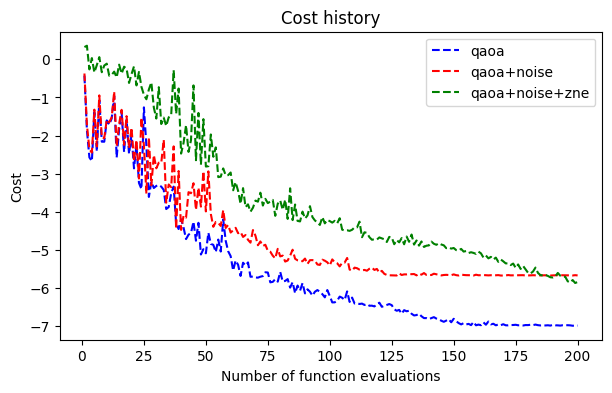

In [15]:
fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa', ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise', ax=ax)
opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne', ax=ax)
plt.savefig("test3-cobyla-noise-linear.png")

In [ ]:
ps = [1, 2, 3, 4, 5, 6]
param_types = [ "extended"]
init_types = ["rand", "ramp"]
mixer_hams = ["x", "xy"]
optimizers = ["Nelder-Mead", "Powell", "COBYLA"]
for p in tqdm(ps):
    for param_type in tqdm(param_types):
        for init_type in tqdm(init_types):
            for mixer_hamiltonian in tqdm(mixer_hams):
                for optimizer in tqdm(optimizers):
                    print("params = %s-%s-%s-%s-%s" % (str(p), str(param_type), str(init_type), str(mixer_hamiltonian), str(optimizer)))
                    q1 = QAOA()
                    qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
                    q1.set_device(qiskit_device)
                    q1.set_circuit_properties(p=p, param_type=param_type, init_type=init_type, mixer_hamiltonian=mixer_hamiltonian)
                    q1.set_backend_properties(n_shots=10000, seed_simulator=1)
                    q1.set_classical_optimizer(method=optimizer, maxiter=200, tol=0.001,
                    optimization_progress=True, cost_progress=True, parameter_log=True)
                    q1.compile(maxcut_qubo)
                    q1.optimize()
                    correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
                    print(correct_solution1)
                    opt_results1 = q1.result
                    noise_model = add_depolarizing_error(NoiseModel(),0.1)
                    q2 = QAOA()
                    qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
                    q2.set_device(qiskit_device)
                    q2.set_circuit_properties(p=p, param_type=param_type, init_type=init_type, mixer_hamiltonian=mixer_hamiltonian)
                    q2.set_classical_optimizer(method=optimizer, maxiter=200, tol=0.001,
                                            optimization_progress=True, cost_progress=True, parameter_log=True)
                    q2.set_backend_properties(n_shots=5000, seed_simulator=1,
                                            noise_model=noise_model)
                    q2.compile(maxcut_qubo)
                    q2.optimize()
                    correct_solution2 = ground_state_hamiltonian(q2.cost_hamil)
                    opt_results2 = q2.result
                    print(correct_solution2)
                    qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
                    q3 = QAOA()
                    q3.set_device(qiskit_device)
                    q3.set_circuit_properties(p=p, param_type=param_type, init_type=init_type, mixer_hamiltonian=mixer_hamiltonian)
                    q3.set_classical_optimizer(method=optimizer, maxiter=200, tol=0.001,
                                            optimization_progress=True, cost_progress=True, parameter_log=True)
                    q3.set_backend_properties(n_shots=5000, seed_simulator=1, noise_model=noise_model)
                    q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',n_batches=64,calibration_data_location="caldata.json")
                    q3.compile(maxcut_qubo)
                    q3.optimize()
                    correct_solution3 = ground_state_hamiltonian(q3.cost_hamil)
                    print(correct_solution3)
                    opt_results3 = q3.result

                    #plot_cost(opt_results2,)

                    fig, ax = plt.subplots(figsize=(7,4))
                    opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa',ax=ax)
                    opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax)
                    opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax)
                    plt.savefig("%s-%s-%s-%s-%s-1.png" % (str(p), str(param_type), str(init_type), str(mixer_hamiltonian), str(optimizer)))
                    fig2, ax2 = plt.subplots(figsize=(7,4))
                    opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax2)
                    opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax2)
                    plt.savefig("%s-%s-%s-%s-%s-2.png" % (str(p), str(param_type), str(init_type), str(mixer_hamiltonian), str(optimizer)))

In [ ]:
from openqaoa import QAOA  
q1 = QAOA()
q1

In [ ]:
from openqaoa.backends import create_device
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q1.set_device(qiskit_device)
q1.set_circuit_properties(p=3,param_type='standard', init_type='ramp', mixer_hamiltonian='x')
q1.set_backend_properties(n_shots=10000, seed_simulator=1)
q1.set_classical_optimizer(method='nelder-mead', maxiter=150, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

In [ ]:
q1.compile(maxcut_qubo)

In [ ]:
q1.optimize()

### 2.2. Results

In [ ]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
print(correct_solution1)

opt_results1 = q1.result
opt_results1.plot_cost(figsize=(7,4),label='qaoa')

## 3. OpenQAOA + noise

### 3.1 Adding a noise model

In [ ]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']

#create depol. noise
def add_depolarizing_error(noise_model,prob):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.015)

### 2.2. Configuration, compilation and optimization

In [ ]:
from openqaoa import QAOA  
q2 = QAOA()
q2

In [ ]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q2.set_device(qiskit_device)
q2.set_circuit_properties(p=3,param_type='standard', init_type='rand', mixer_hamiltonian='x')
q2.set_classical_optimizer(method='nelder-mead', maxiter=150, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)
q2.set_backend_properties(n_shots=5000, seed_simulator=1,
                          noise_model=noise_model)

In [ ]:
q2.compile(maxcut_qubo)

In [ ]:
q2.optimize()

### 2.3 Results

In [ ]:
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
correct_solution2 = ground_state_hamiltonian(q2.cost_hamil)
print(correct_solution2)

opt_results2 = q2.result

#plot_cost(opt_results2,)

fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise')


In [ ]:
fig.savefig("comparison.png")

## 4. OpenQAOA + noise + ZNE

### 4.1. Configuration

In [ ]:
from openqaoa import QAOA  
q3 = QAOA()
q3

In [ ]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q3.set_device(qiskit_device)
q3.set_circuit_properties(p=3,param_type='standard', init_type='rand', mixer_hamiltonian='x')
q3.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)
q3.set_backend_properties(n_shots=5000, seed_simulator=1,
                          noise_model=noise_model
                         )

### 4.2. Adding ZNE technique

In [ ]:
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)

### 4.3. compilation and optimization

In [ ]:
q3.compile(maxcut_qubo)

In [ ]:
q3.optimize()

### 4.4 Results

In [ ]:
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
correct_solution3 = ground_state_hamiltonian(q3.cost_hamil)
print(correct_solution3)

opt_results3 = q3.result

#plot_cost(opt_results2,)

fig, ax = plt.subplots(figsize=(7,4))
opt_results1.plot_cost(figsize=(7,4),color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax)
opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax)

fig2, ax2 = plt.subplots(figsize=(7,4))
opt_results2.plot_cost(figsize=(7,4),color='red',label='qaoa+noise',ax=ax2)
opt_results3.plot_cost(figsize=(7,4),color='green',label='qaoa+noise+zne',ax=ax2)


## 5. Variable depolarizing noise over OpenQAOA, OpenQAOA+noise and OpenQAOA+noise+zne

In [ ]:
noise_probs = range(0,50,5)
for i in noise

## Requesting Mitiq ZNE mitigation and compiling

In [ ]:
q.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q.set_circuit_properties(p=2)
q.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

q.compile(maxcut_qubo)

## Optimization

In [ ]:
q.optimize()

## Getting the solution

In [ ]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution = ground_state_hamiltonian(q.cost_hamil)
correct_solution

In [ ]:
opt_results = q.result
opt_results.plot_cost()


## Comparing with standard QAOA, with noise

In [ ]:
q1 = QAOA()
q1.set_device(qiskit_device)

noise_model = add_depolarizing_error(NoiseModel(),0.3)
q1.set_circuit_properties(p=2)
q1.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

""" q1.set_backend_properties(n_shots=1024, seed_simulator=1, noise_model = noise_model) """

q1.compile(maxcut_qubo)

In [ ]:
q1.optimize()

In [ ]:
correct_solution = ground_state_hamiltonian(q1.cost_hamil)
correct_solution

In [ ]:
opt_results = q1.result
opt_results.plot_cost()

## Comparing with standard QAOA, with IBM Quantum backend

In [ ]:
from qiskit import IBMQ
from openqaoa import create_device
from qiskit_ibm_provider import IBMProvider

In [ ]:
IBMQ.load_account()

In [ ]:
ibm_device = create_device(location='ibmq', 
                                name='ibm_osaka',
                                hub='ibm-q', 
                                group='open', 
                                project='main')

In [ ]:
q2 = QAOA()
q2.set_device(ibm_device)
q2.compile(maxcut_qubo)

In [ ]:
q2.optimize()

In [ ]:
correct_solution = ground_state_hamiltonian(q2.cost_hamil)
correct_solution

## Comparing with OpenQAOA + Mitiq ZNE, with IBM Quantum backend

In [ ]:
q3 = QAOA()
q3.set_device(ibm_device)
q3.set_backend_properties(n_shots=1024, seed_simulator=1)
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q3.compile(maxcut_qubo)

In [ ]:
q3.optimize()

In [ ]:
correct_solution = ground_state_hamiltonian(q3.cost_hamil)
correct_solution

In [ ]:
from openqaoa.backends.qaoa_backend import (
    DEVICE_NAME_TO_OBJECT_MAPPER,
    DEVICE_ACCESS_OBJECT_MAPPER,
)

In [ ]:
print(DEVICE_NAME_TO_OBJECT_MAPPER.keys())